Let's first install and import all the necessary libraries and then mount google drive to the notebook.

In [1]:
!pip install fiftyone
!pip install import_ipynb

import fiftyone
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import os
from PIL import Image
import shutil
import random
import json

from IPython.display import clear_output
clear_output()

In [2]:
import import_ipynb
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Also import the function calculate_iou() from utils.

In [4]:
%cd /content/drive/MyDrive/Object_detection

from utils import calculate_iou

%cd /content/

/content/drive/MyDrive/Object_detection
/content


The first thing to do after importing the necessary libraries is to download the dataset. This project uses images from coco-2017 dataset, specifically looking for the class 'person'. This json file containing the dataset of 250 images is stored in the variable called 'dataset'.

In [5]:
dataset = fiftyone.zoo.load_zoo_dataset(
    'coco-2017', label_types = ['detections', 'segmentations'], classes = 'person', max_samples = 140)

clear_output()

In [ ]:
dataset

Name:        coco-2017-140
Media type:  image
Num samples: 420
Persistent:  False
Tags:        []
Sample fields:
    id:            fiftyone.core.fields.ObjectIdField
    filepath:      fiftyone.core.fields.StringField
    tags:          fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:      fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    detections:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

fiftyone also downloads a json file each for training, validation and test images which contains information about each of the bounding boxes in the dataset.

In [6]:
# Loading the json files of training, validation and test images.

with open('/root/fiftyone/coco-2017/train/labels.json') as json_data:
    train_data = json.load(json_data)

with open('/root/fiftyone/coco-2017/validation/labels.json') as json_data:
    val_data = json.load(json_data)

with open('/root/fiftyone/coco-2017/test/labels.json') as json_data:
    test_data = json.load(json_data)

# Let's have a look at train_data
train_data

{'info': {'description': 'COCO 2017 Dataset',
  'url': 'http://cocodataset.org',
  'version': '1.0',
  'year': 2017,
  'contributor': 'COCO Consortium',
  'date_created': '2017/09/01',
  'licenses': [{'url': 'http://creativecommons.org/licenses/by-nc-sa/2.0/',
    'id': 1,
    'name': 'Attribution-NonCommercial-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nc/2.0/',
    'id': 2,
    'name': 'Attribution-NonCommercial License'},
   {'url': 'http://creativecommons.org/licenses/by-nc-nd/2.0/',
    'id': 3,
    'name': 'Attribution-NonCommercial-NoDerivs License'},
   {'url': 'http://creativecommons.org/licenses/by/2.0/',
    'id': 4,
    'name': 'Attribution License'},
   {'url': 'http://creativecommons.org/licenses/by-sa/2.0/',
    'id': 5,
    'name': 'Attribution-ShareAlike License'},
   {'url': 'http://creativecommons.org/licenses/by-nd/2.0/',
    'id': 6,
    'name': 'Attribution-NoDerivs License'},
   {'url': 'http://flickr.com/commons/usage/',
    'id': 7

This contains a lot of unnecessary information, as you can see. To only save relevant information about each of the bounding boxes, we create a function to make a more readable dataframe storing bbox_id, img_id, bbox_values and image_path.

In [7]:
def create_bbox_df(data: dict, file_type: str) -> pd.DataFrame:
    '''
    Parameters:
      data: A dictionary (.json file) which contains a lot of unnecessary data.
      file_type: train folder or validation_folder.
    
    Returns:
      A dataframe with columns image_id, bbox_id, bbox_value and image path.
    '''
    
    image_paths = {}
    bboxes = {}
    img_id = []
    bbox_df = pd.DataFrame()
    
    for i in data['images']:
        image_paths[i['id']] = f'/root/fiftyone/coco-2017/{file_type}/data/' + i['file_name']                 # Saving the paths


    for i in data['annotations']:
        if(i['category_id'] == 1):                                                                     # Checking if the class is 'Person'
          bboxes[i['id']] = i['bbox']
          img_id.append(i['image_id'])
        
    bbox_df['bbox_id'] = bboxes.keys()
    bbox_df['bbox_values'] = bboxes.values()
    bbox_df['img_id'] = img_id
    bbox_df['image_path'] = bbox_df['img_id'].map(image_paths)
    

    bbox_df = bbox_df.sort_values(by = ['img_id', 'bbox_id'])
    bbox_df.reset_index(inplace = True, drop = True)
    
    return bbox_df

In [8]:
train_df = create_bbox_df(train_data, 'train')
val_df = create_bbox_df(val_data, 'validation')

val_df = val_df[val_df['img_id'].isin(val_df['img_id'].unique()[:30])]                      # Selecting only 30 images for validation for simplicity

train_df.head()

,bbox_id,bbox_values,img_id,image_path
0,453991,"[167.58, 162.89, 310.61, 465.19]",36,/root/fiftyone/coco-2017/train/data/0000000000...
1,198565,"[203.39, 260.43, 65.69, 73.04]",49,/root/fiftyone/coco-2017/train/data/0000000000...
2,254537,"[118.43, 261.32, 56.91, 62.93]",49,/root/fiftyone/coco-2017/train/data/0000000000...
3,1211660,"[119.34, 334.21, 11.94, 33.57]",49,/root/fiftyone/coco-2017/train/data/0000000000...
4,2007474,"[284.34, 333.4, 10.88, 27.43]",49,/root/fiftyone/coco-2017/train/data/0000000000...


Before anything else, it's important to check if all the bounding boxes and images in the dataframe are correctly in allignment with each other. 

show_bounding_boxes() does exactly this. After passing in the dataframe and a row from the dataframe to the function, it simply plots all the true bounding boxes of that image.

In [10]:
def show_bounding_boxes(bbox_df: pd.core.frame.DataFrame, bbox_df_row: pd.core.series.Series) -> None:
  '''
  Parameters:
    bbox_df: Pandas Dataframe containing the columns bbox_id, bbox_values, img_id and image_path
    bbox_df_row: A row from the dataframe bbox_df

  Output:
    The function prints all the true bounding boxes for the selected image.
  '''

  image_id = bbox_df_row['img_id']
  rows = bbox_df.groupby(by = bbox_df['img_id']).get_group(image_id).reset_index(drop = True)
  img = plt.imread(bbox_df_row['image_path'])

  plt.imshow(img)

  for idx in rows.index:
    bbox = rows.loc[idx, 'bbox_values']
    x = int(bbox[0])
    y = int(bbox[1])
    w = bbox[2]
    h = bbox[3]
    bottom_x = int(x + w)
    bottom_y = int(y + h)

    plt.imshow(cv2.rectangle(img, (x, y), (bottom_x, bottom_y), (255, 0, 0), 2))


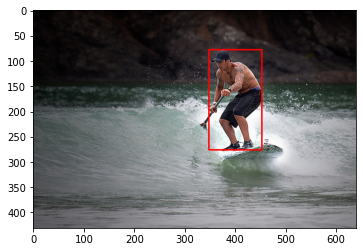

In [46]:
show_bounding_boxes(train_df, train_df.loc[350, :])

And the idea was right! 3 people in the image and 3 bounding boxes, perfect!

After creating dataframes to handle training and validation bounding boxes, it's now time for test images. Test images have no information about true bounding boxes. The downloaded json file is filtered and converted to a more readable dataframe containing only the image name and image path by the function defined below.

In [ ]:
def get_test_images(data: dict) -> pd.DataFrame:
  '''
  Parameters:
    data: A dictionary (.json file) which contains a lot of unnecessary data.
    
  Returns:
    A dataframe with columns image_name and image_path.
  '''

  image_names = []
  df = pd.DataFrame()

  for i in data['images']:
    image_names.append(i['file_name'])
  
  df['image_name'] = image_names
  df['image_paths'] = '/root/fiftyone/coco-2017/test/data/' + df['image_name']
  return df

In [ ]:
test_df = get_test_images(test_data)

test_df.head()

,image_name,image_paths
0,000000001024.jpg,/root/fiftyone/coco-2017/test/data/00000000102...
1,000000001418.jpg,/root/fiftyone/coco-2017/test/data/00000000141...
2,000000000080.jpg,/root/fiftyone/coco-2017/test/data/00000000008...
3,000000001367.jpg,/root/fiftyone/coco-2017/test/data/00000000136...
4,000000000016.jpg,/root/fiftyone/coco-2017/test/data/00000000001...


Now is when we need to familiariaze ourselves with Selecive Search Segmentation. Let's simply run the algorithm on an image and have a look at the result.

1695


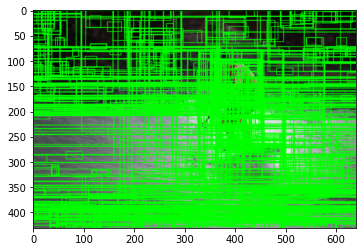

In [47]:
img_path = train_df.loc[350, 'image_path']
img = plt.imread(img_path)

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

im = img
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

plt.imshow(imOut)
print(len(rects))

And the algorithm, as predicted, came up with 3401 region proposals for the image. 

We need to use the training dataframe and the Selective Search algorithm to create images to train the model. This is actually a lot simpler than it sounds.

The following function reads a dataframe (be it train_df or val_df) row by row, reads the true bounding box as 'bbox', reads the image from the image path and runs the selective search algorithm for that image. Thousands of region proposals produced by the algorithm are each passed to the function IOU along with the true bounding box to find out the overlap between the two.

If there is 70% overlap, the region proposal is classified as 1 (for object) and 0 (for background) if there is less than 30% overlap.

We also set a constraint to not produce more than 30 object and background regions each per image. 

This process is repeated for all the bounding boxes in the dataset.

In [ ]:
def generate_region_proposals_and_labels(bbox_df: pd.DataFrame) -> tuple([list, list]):
  '''
  Parameters:
    bbox_df: Dataframe containing img_id, bbox_id, bbox_values and img_paths.
  
  Returns:
    tuple containing 2 lists viz., images and labels.
  '''

  images = []
  labels = []

  for i in range(len(bbox_df)):
    try:
      img_path = bbox_df.loc[i, 'image_path']
      img = plt.imread(img_path)

      # If the image is a single channel b&w picture, then create three channels
      if len(img.shape)!=3:
        img = cv2.merge((img, img, img))

      bbox = bbox_df.loc[i, 'bbox_values']

      # Running Selective Search algorithm on the images
      ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

      ss.setBaseImage(img)
      ss.switchToSelectiveSearchFast()
      rects = ss.process()

      positives_count = 0
      negatives_count = 0

      for rect in rects:
        x, y, w, h = rect
        imOut = img.copy()
        iou = calculate_iou(rect, bbox)

        if (iou > 0.7) and (positives_count < 30):
          positives_count += 1
          imOut = imOut[y:y+h, x:x+w, :]
          resized_imOut = cv2.resize(imOut, (224,224), interpolation = cv2.INTER_AREA)
          images.append(resized_imOut)
          labels.append(1)
        
        elif (iou < 0.3) and (negatives_count < 30):
          negatives_count += 1
          imOut = imOut[y:y+h, x:x+w, :]
          resized_imOut = cv2.resize(imOut, (224,224), interpolation = cv2.INTER_AREA)
          images.append(resized_imOut)
          labels.append(0)

    except Exception as e:
      print(e)
      print(img_path, '\n')
      continue

  return images, labels

Let's now use this function to create lists of training images, training labels, validation images and validation labels.

In [ ]:
train_images, train_labels = generate_region_proposals_and_labels(train_df)
val_images, val_labels = generate_region_proposals_and_labels(val_df)

Since this project needs to use GPUs, we'll be using Google Colab, and so let's store all the training, validation and test images to Google Drive.

The function accepts google drive folder path as a parameter inside which we intend to store the images. If the folder already exists, we overwrite with a new folder. The function creates 2 more folders inside the passed folder path namely 0 and 1, which contain background and object images respectively.

In [ ]:
def save_images(folder_path: str, images: list, labels: list) -> None:
  '''
  Parameters:
    folder_path: string value specifying the path into which the images are to be uploaded.
    images: list of images.
    labels: list of labels.

  '''

  if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print('Deleting the old folder..')

  os.makedirs(folder_path)
  print('New folder created')
  
  object_images_path = f'{folder_path}/1'
  background_images_path = f'{folder_path}/0'
  
  os.mkdir(object_images_path)
  os.mkdir(background_images_path)

  for i in range(len(images)):
      
      if labels[i] == 1:
          result = Image.fromarray(images[i])
          image_path = object_images_path + '/' + str(i) + '.jpg'
          result.save(image_path)
          
      if labels[i] == 0:
          result = Image.fromarray(images[i])
          image_path = background_images_path + '/' + str(i) + '.jpg'
          result.save(image_path)
          
  print('Successfully uploaded images.')

The idea is to have folders created in the following fashion:

Train Folder:

            0: background images
            1: object images

Validation Folder:

            0: background images
            1: object images

In [ ]:
train_folder_path = 'drive/MyDrive/Object_detection/Training_images'
val_folder_path = 'drive/MyDrive/Object_detection/Validation_images'

save_images(train_folder_path, train_images, train_labels)
save_images(val_folder_path, val_images, val_labels)

Deleting the old folder..
New folder created
Successfully uploaded images.
Deleting the old folder..
New folder created
Successfully uploaded images.


Finally, let's do the same to test images. These images are directly uploaded as a whole into a separate folder.

In [ ]:
test_folder_path = 'drive/MyDrive/Object_detection/Test_images/'

if os.path.exists(test_folder_path):
  shutil.rmtree(test_folder_path)

os.mkdir(test_folder_path)

for i in range(len(test_df)):
    img = plt.imread(test_df['image_paths'][i])
    img = Image.fromarray(img)
    img_save_path = test_folder_path  + test_df['image_name'][i]
    img.save(img_save_path)